# Computer Class 4 - Linear Discriminant Analysis and logistic regression

The examples and exercises in this computer class introduce the student to linear techniques for classification, in particular linear regression of an indicator matrix, LDA, reduced-rank LDA and logistic regression. This computer class can be used in conjunction with chapters 6 and 6 of the reader.

*Authors: Cees Diks and Bram Wouters, Faculty Economics and Business, University of Amsterdam (UvA)* <br>
*Copyright (C): UvA (2024)* <br>
*Credits: some of the examples and exercises are inspired by [this](https://sebastianraschka.com/Articles/2014_python_lda.html) blog by Sebastian Raschka.*

## Part 1: binary classification

### The Iris flower data set
The famous Iris flower data set consists of 150 observations of three types of Iris flowers, 50 observations per type. The names of the types are Setosa, Versicolor and Virginica. Apart from the type, each observation consists of 4 properties (features) of the flower, namely sepal length, sepal width, petal length and petal width. The Iris flower data set is often used to illustrate classification methods.

In the cell below we import the data set from the scikit-learn database and display a number of properties. We also center the features.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn import datasets
from sklearn.model_selection import KFold

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X - np.mean(X, axis=0) # Centering the features (ignoring classes)

K_classes = len(iris.target_names)

print("There are {} classes. The names of the classes are: {}.\n".format(K_classes, iris.target_names))
print("There are {} features. The names of the features are:\n {}.\n".format(X.shape[1], iris.feature_names))
print("There are {} observations.".format(len(y)))

There are 3 classes. The names of the classes are: ['setosa' 'versicolor' 'virginica'].

There are 4 features. The names of the features are:
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'].

There are 150 observations.


### Linear regression of an indicator matrix
The function `train_lr_classification` in the cell below uses linear regression of an indicator matrix to train a classification model. It returns a predictor function `G`, which can be used to predict the classes of observations given their features.

In [53]:
def train_lr_classification(X, y, K):
    
    N = len(y)
    
    Y_indicator = np.zeros((N,K))
    Y_indicator[np.arange(N), y] = 1.   # Use fancy indexing to create the indicator matrix (see McKinney, p.102)
    
    # Creating the matrix X, with a first column of ones for the bias
    X_with_bias = np.hstack((np.ones((N,1)), X))
    
    # Standard result for OLS with multiple dependent variables
    beta = np.linalg.pinv(X_with_bias).dot(Y_indicator) 
    
    # Defining a predictor function
    def G(X_new):
        
        X_new = np.array(X_new)    # Making sure that the predictor function also accepts lists
        N_new = X_new.shape[0]
        X_new_with_bias = np.hstack((np.ones((N_new,1)), X_new))   
        
        return np.argmax(X_new_with_bias @ beta, axis=1)
    
    return G

**Example:** here we train the linear regression model on the full Iris flower data set. Subsequently, we let the fitted prediction function act on the features of the 150 observations of the data set and print the predicted classes.

In [54]:
G_fitted =  train_lr_classification(X, y, K_classes)

G_fitted(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

###  Estimating the accuracy with cross-validation
As in the case of regression/forecasting problems, we can use K-fold cross-validation to estimate the prediction error of our classification models. The main difference is the choice of loss function. One typical error metric is the accuracy, which measures fraction of correct predictions. In the function `accuracy` below, we apply K-fold cross-validation to estimate this error and the standard deviation of the error estimate.

In [55]:
def accuracy(training_method, X, y, K_classes, K_cv=10, runs=1):
    
    N = len(y)
    
    misclassifications = np.array([])
    for run in range(runs):
        
        cv_folds = KFold(n_splits=K_cv, shuffle=True) # Randomly creating new folds for each run
        
        for indices_train, indices_test in cv_folds.split(X):
            
            X_train = X[indices_train]
            y_train = y[indices_train]
            X_test = X[indices_test]
            y_test = y[indices_test]

            G_fitted = training_method(X_train, y_train, K_classes) # Fitting model in training data
            y_fitted_test = G_fitted(X_test) # Using fitted model to predict on test data

            no_misclassifications = np.sum(y_fitted_test != y_test) # Counting number of prediction errors test data
            misclassifications = np.append(misclassifications, no_misclassifications)
    
    accuracy = 1 - np.sum(misclassifications)/(N*runs)
    std_error = np.std(misclassifications, ddof=1)*np.sqrt(K_cv/runs)/N
    
    return accuracy, std_error

**Example:** computing the accuracy of the linear regression model for classification.

In [56]:
accuracy(train_lr_classification, X, y, K_classes, K_cv=10, runs=2)

(np.float64(0.8233333333333334), np.float64(0.02479152845310139))

### Visualizing classification regions 
You can use the function `plot_classification` to plot both the data set and the classification regions, given a predictor function `G`.

In [57]:
def plot_classification(X, y, K, dir1, dir2, G=None, title=None, labels=iris.target_names):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    if title:
        ax.set_title(title)
    colors = ['red', 'blue', 'lightgreen']
    
    if np.isscalar(dir1):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir1] = 1.
        dir1 = dir_temp    
    if np.isscalar(dir2):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir2] = 1.
        dir2 = dir_temp
    dir1 = dir1/np.linalg.norm(dir1)
    dir2 = dir2/np.linalg.norm(dir2)
    
    # Plotting the observations in the data set
    for k in range(K):
        boolean_index = y==k
        ax.scatter(np.dot(X[boolean_index], dir1), np.dot(X[boolean_index], dir2), c=colors[k], label=labels[k])    
    
    # Creating classification regions
    if G:
        points = 200
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        x_range = np.linspace(xmin, xmax, points)
        y_range = np.linspace(ymin, ymax, points)
        xx, yy = np.meshgrid(x_range, y_range)
    
        G_grid = G(np.outer(xx,dir1) + np.outer(yy,dir2)).reshape(points,points)
    
        ax.contourf(x_range, y_range, G_grid, 2, alpha=.2, colors=colors)
    
    ax.set_xlabel("Direction 1: {}".format(dir1))
    ax.set_ylabel("Direction 2: {}".format(dir2))

    ax.legend();

**Example:** plot of just the data set. On the axes we have chosen the second and fourth feature (sepal width and petal width, respectively), corresponding to the `1` and `3` in the cell below.

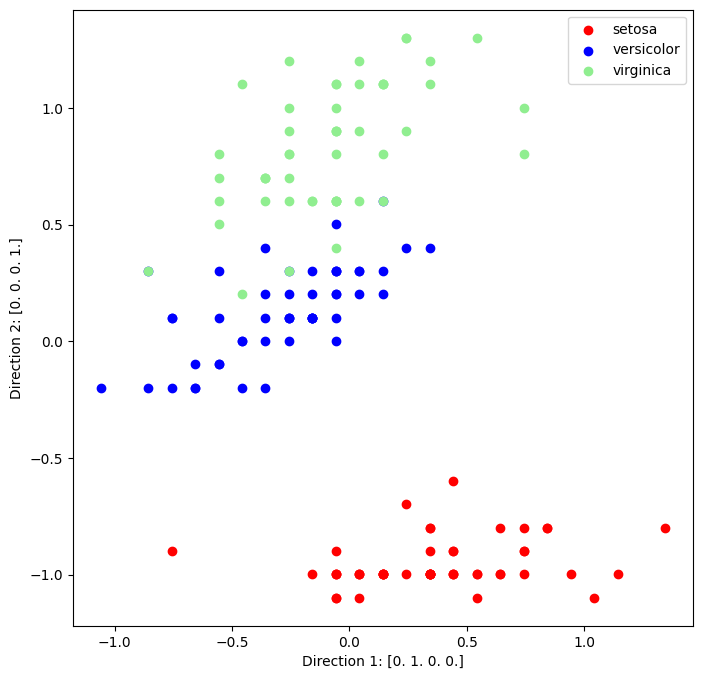

In [58]:
plot_classification(X, y, K_classes, 1, 3)

**Example:** the same plot as in the previous example, but now including the classification regions as predicted by the linear regression method.

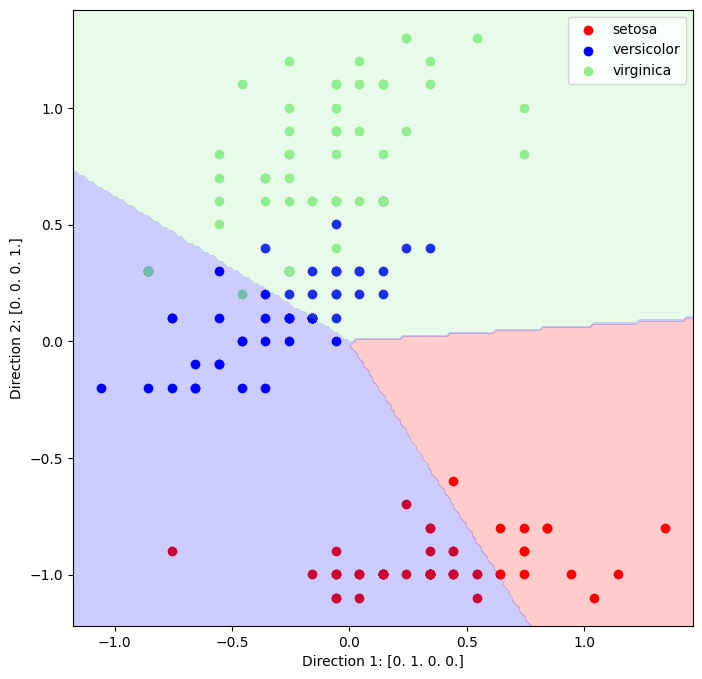

In [59]:
G_fitted =  train_lr_classification(X, y, K_classes)

plot_classification(X, y, K_classes, 1, 3, G=G_fitted)

**Example:** the function `plot_classification` also allows for linear combinations of features on the axes of the plotted graph. These linear combinations are represented as vectors in feature space. In the cell below, we have (arbitrarily) chosen the vectors `[-2,1,0,1]` and `[3,2,1,0]`.

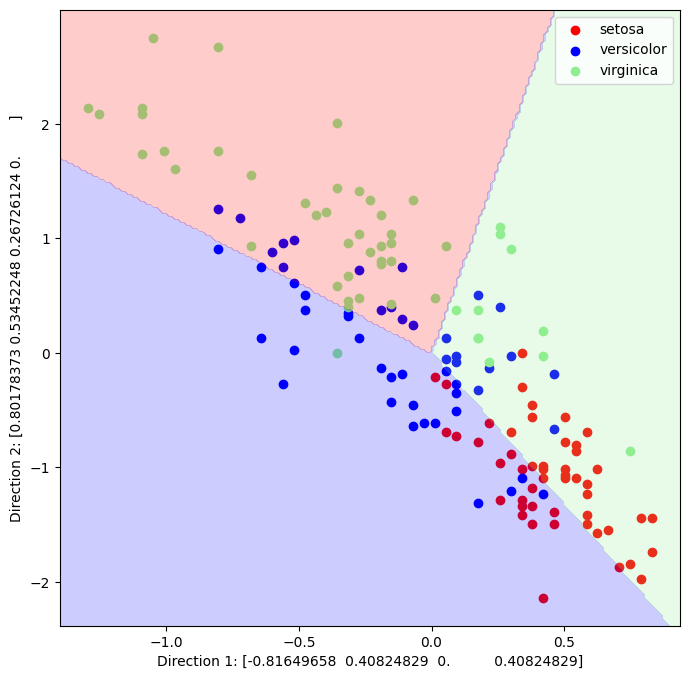

In [60]:
plot_classification(X, y, K_classes, [-2,1,0,1], [3,2,1,0], G=G_fitted)

### Dimension reduction (the naive way)
So far we have used all four input features in our classification model. One option is to reduce the dimension of the feature space by naively selecting features. This is done in the following two examples.

**Example:** creating a linear regression model based on only the second and fourth feature (sepal width and petal width, respectively).

(np.float64(0.8406666666666667), np.float64(0.009083476198178382))


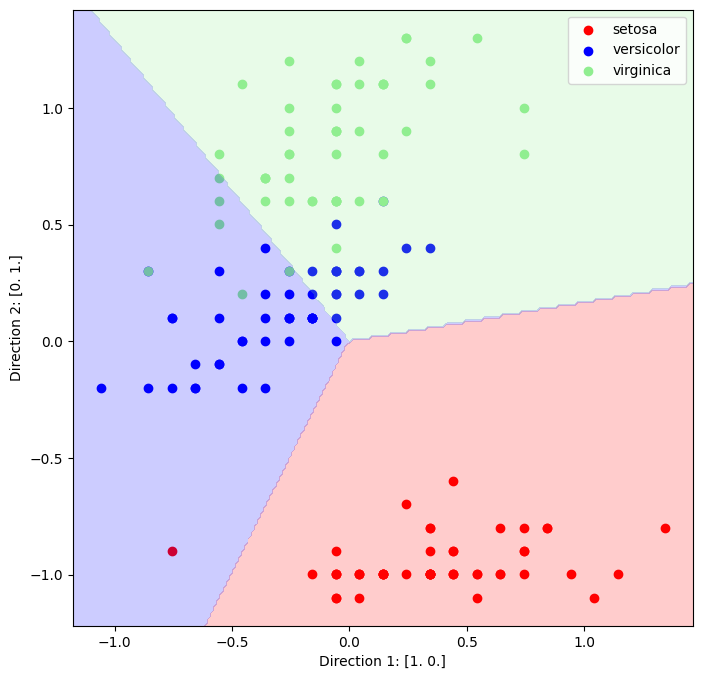

In [61]:
X_reduced = X[:,[1,3]]
G_fitted =  train_lr_classification(X_reduced, y, K_classes)

print(accuracy(train_lr_classification, X_reduced, y, K_classes, K_cv=10, runs=10))
plot_classification(X_reduced, y, K_classes, 0, 1, G=G_fitted)

**Example:** creating a linear regression model based on only the first and fourth feature (sepal length and petal width, respectively). The performance of this model is poor (around 68% accuracy) due to masking of the Versicolor class. This is a typical problem of linear regression with an indicator matrix.

(np.float64(0.6853333333333333), np.float64(0.012063431305383562))


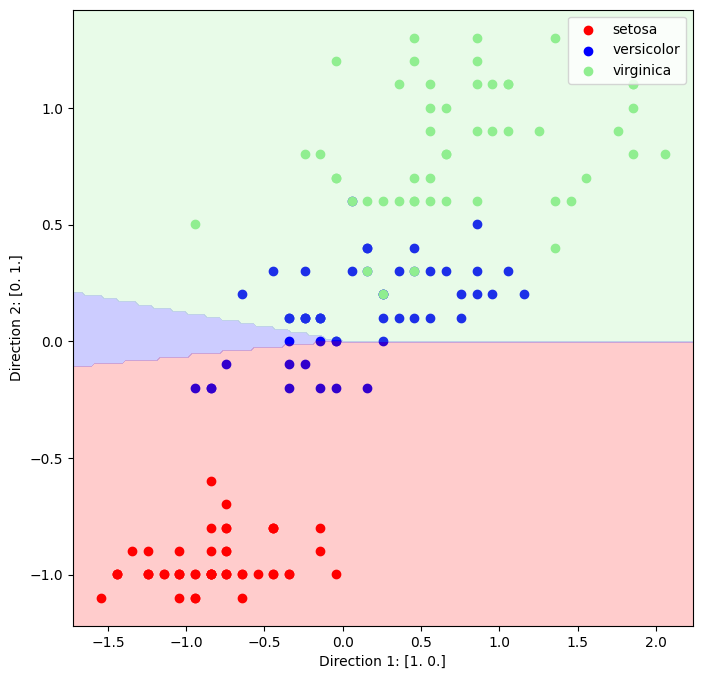

In [62]:
X_reduced = X[:,[0,3]]
G_fitted =  train_lr_classification(X_reduced, y, K_classes)

print(accuracy(train_lr_classification, X_reduced, y, K_classes, K_cv=10, runs=10))
plot_classification(X_reduced, y, K_classes, 0, 1, G=G_fitted)

## Part 2: Linear Discriminant Analysis for classification 

**Exercise 1:** write a function `train_lda_classification` that uses LDA to predict the class of Iris flowers. Similar to the function `train_lr_classification`, it needs features (`X`), target variables/classes (`y`) and the number of classes (`K`) as input. And just like `train_lr_classification`, the function should return a prediction function `G`. (Hint: if you want to keep your code uncluttered, you may want to use additional functions to perform small tasks, e.g. for computing the prior probabilities, the class means and the common covariance matrix.)

In [63]:
def train_lda_classification(X: np.ndarray, y: np.ndarray, K: int):
    classes = np.arange(K)
    pi_hats = np.array([np.mean(y == c) for c in classes])
    mu_hats = np.array([np.mean(X[y == c], axis=0) for c in classes])
    
    def _inner_sum(k: int):
        return np.sum([np.outer(x - mu_hats[k], x - mu_hats[k]) for x in X[y == k]], axis=0)

    sigma_hat = np.sum([_inner_sum(k) for k in classes], axis=0) /( len(X) - len(classes))
    sigma_hat_inverse = np.linalg.inv(sigma_hat)


    def delta_k(x: np.ndarray, k: int) -> float:
        return (-1/2) * (x - mu_hats[k]).T @ sigma_hat_inverse @ (x - mu_hats[k]) + np.log(pi_hats[k])

    def predictor(x: np.ndarray) -> np.ndarray:
        return np.array([np.argmax([delta_k(x_i, k) for k in classes]) for x_i in x])
    return predictor

**Exercise 2:** run the following line to compute the accuracy of your implementation of LDA.

In [64]:
accuracy(train_lda_classification, X, y, K_classes, K_cv=10, runs=20)

(np.float64(0.98), np.float64(0.002362937350027786))

**Example:** the cell below applies your LDA implementation to a data set with only the second and fourth feature (sepal width and petal width, respectively). Compare the results with the first example of the previous section.

(np.float64(0.9626666666666667), np.float64(0.004164949140962149))


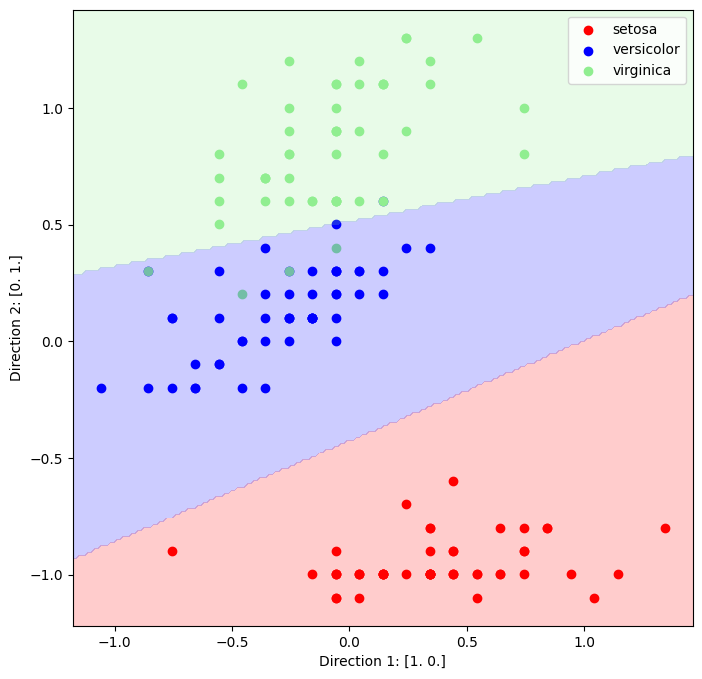

In [65]:
X_projected = X[:,[1,3]]
G_fitted =  train_lda_classification(X_projected, y, K_classes)

print(accuracy(train_lda_classification, X_projected, y, K_classes, K_cv=10, runs=10))
plot_classification(X_projected, y, K_classes, 0, 1, G=G_fitted)

**Example:** the cell below applies your LDA implementation to a data set with only the first and fourth feature (sepal length and petal width, respectively). Compare the results with the second example of the previous section. Note that LDA does not have the problem of masking.

(np.float64(0.956), np.float64(0.004466611387164841))


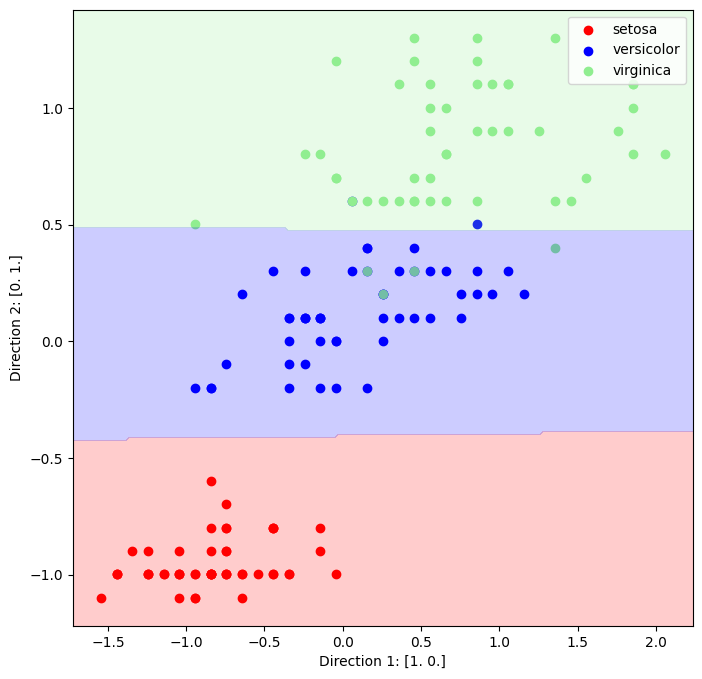

In [66]:
X_projected = X[:,[0,3]]
G_fitted =  train_lda_classification(X_projected, y, K_classes)

print(accuracy(train_lda_classification, X_projected, y, K_classes, K_cv=10, runs=10))
plot_classification(X_projected, y, K_classes, 0, 1, G=G_fitted)

**Example:** suppose that the abundancies in nature of the different species are not equal, but 1:18:1 (for Setosa, Versicolor and Virginica, respectively). Create a new LDA training function `train_lda_classification_nature` that takes into account the prior probabilities of nature. Plot the figures of the previous two examples again using the new training function and comment on the differences

In [67]:
def get_centroids(X, y, K):
    classes = np.arange(K)
    mu_hats = np.array([np.mean(X[y == c], axis=0) for c in classes])
    return mu_hats

def get_within_class_covariance(X, y, K_classes, centroids):
    classes = np.arange(K_classes)
    sigma_hat = np.sum([np.sum([np.outer(x - centroids[k], x - centroids[k]) for x in X[y == k]], axis=0) for k in classes], axis=0) / (len(X) - len(classes))
    return sigma_hat

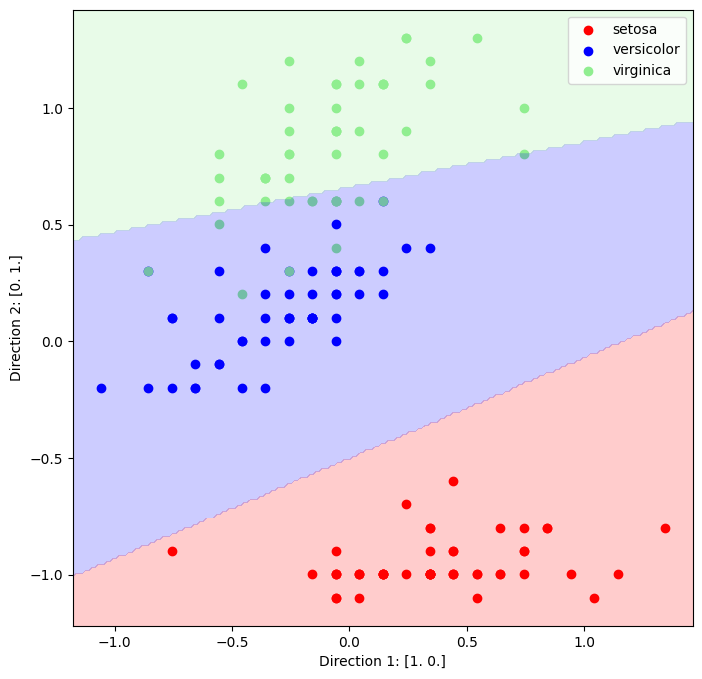

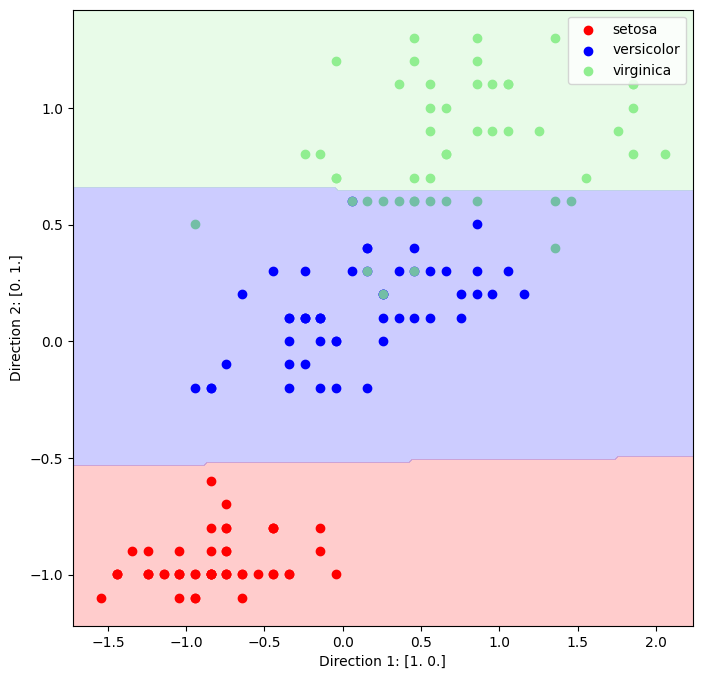

In [68]:
def train_lda_classification_nature(X, y, K_classes):
    
    probs = np.array([0.05, 0.9, 0.05])
    centroids = get_centroids(X, y, K_classes)
    cov = get_within_class_covariance(X, y, K_classes, centroids)
    inv_cov = np.linalg.inv(cov)
    
    def G(X_new):
        
        deltas = np.zeros((X_new.shape[0], K_classes))
        for k in range(K_classes):
            deltas[:,k] = (X_new - centroids[k]/2) @ inv_cov @ centroids[k] + np.log(probs[k])
        
        return np.argmax(deltas, axis=1)
    
    return G

X_projected = X[:,[1,3]]
G_fitted =  train_lda_classification_nature(X_projected, y, K_classes)
plot_classification(X_projected, y, K_classes, 0, 1, G=G_fitted)

X_projected = X[:,[0,3]]
G_fitted =  train_lda_classification_nature(X_projected, y, K_classes)
plot_classification(X_projected, y, K_classes, 0, 1, G=G_fitted)

**Answer:** the classification region of Versicolor has increased, in order to account for the higher abundance of Versicolor in nature.

### Reduced-rank LDA 

**Example:** write a function `get_linear_discriminants` that compute the eigenvalues and eigenvectors of ${\bf \Sigma}^{-1} {\bf B},$ where ${\bf \Sigma}$ is the within-class covariance matrix and ${\bf B}$ is the between-class covariance matrix.

Use the eigenvalues to compute the explained variance per linear discriminant (direction).

In [69]:
def get_between_class_covariance(centroids, K_classes):
    return np.dot(centroids.T, centroids)/(K_classes - 1)

def get_linear_discriminants(X, y, K_classes):
    
    centroids = get_centroids(X, y, K_classes)
    Sigma = get_within_class_covariance(X, y, K_classes, centroids)
    B = get_between_class_covariance(centroids, K_classes)
    
    eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(Sigma), B))
    
    return eig_vals.real, eig_vecs.real

eig_vals, eig_vecs = get_linear_discriminants(X, y, K_classes)

print("Explained variance per eigenvalue/linear discriminant:")
for i, eig_val in enumerate(eig_vals):
    print("eigenvalue {0}: {1:.2%}".format(i+1, np.abs(eig_val/sum(eig_vals))))

Explained variance per eigenvalue/linear discriminant:
eigenvalue 1: 99.12%
eigenvalue 2: 0.88%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


**Example:** project the four input features onto the linear discriminants, i.e. compute ${\bf Z} = {\bf X} {\bf V},$ where the columns of ${\bf V}$ are the normalized linear discriminant (directions). 

Then compute the accuracies of an LDA model taking into account different numbers of linear discriminants, i.e. calculate the accuracy of the LDA model taking into account one, two, three or four linear discriminants.

Finally, plot the classification regions of the LDA model based on the first and second linear discriminant.

accuracy taking into account the first 1 linear discriminants: (np.float64(0.98), np.float64(0.0032133280243609825))
accuracy taking into account the first 2 linear discriminants: (np.float64(0.9793333333333334), np.float64(0.003506607519568778))
accuracy taking into account the first 3 linear discriminants: (np.float64(0.9793333333333334), np.float64(0.0036323771639011444))
accuracy taking into account the first 4 linear discriminants: (np.float64(0.9793333333333334), np.float64(0.003376155910464157))


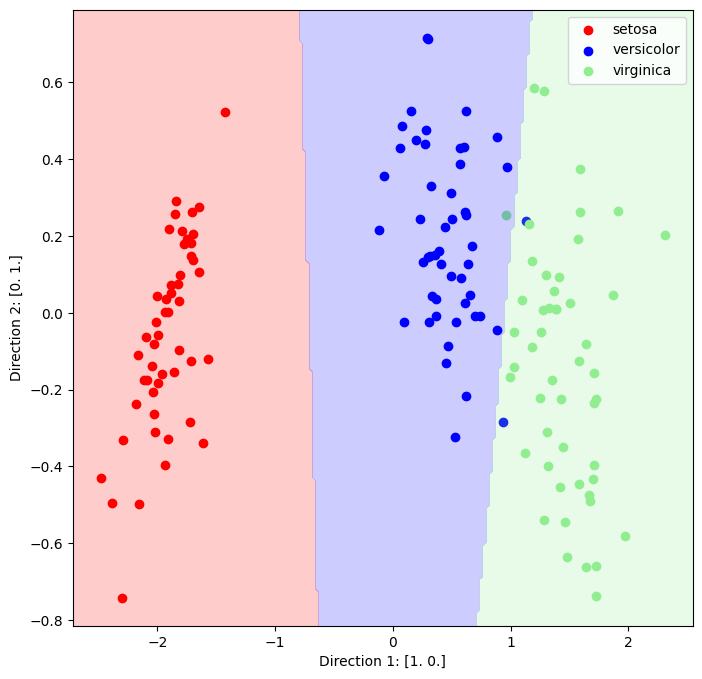

In [70]:
# Projecting onto the linear discriminant (directions)
Z = np.dot(X, eig_vecs)

# Computing accuracies
for i in range(len(eig_vals)):
    
    Z_reduced = Z[:,:i+1]
    
    acc = accuracy(train_lda_classification, Z_reduced, y, K_classes, K_cv=10, runs=10)
    print("accuracy taking into account the first {0} linear discriminants: {1}".format(i+1, acc))

# Plotting
Z_reduced = Z[:,:2]
G_fitted =  train_lda_classification(Z_reduced, y, K_classes)
plot_classification(Z_reduced, y, K_classes, 0, 1, G=G_fitted)

### Confusion matrix

**Example:** create a function `confusion` that uses K-fold cross-validation to estimate the confusion matrix. The function should return the confusion matrix as a DataFrame. In order to help you, we have created an empty confusion matrix in the cell below. (Hint: you can use large parts of the function `accuracy`.)

In [71]:
import pandas as pd

df = pd.DataFrame(np.zeros((K_classes,K_classes)).astype(int), index=iris.target_names, columns=iris.target_names)
df.columns.name = 'Actual class:'
df.index.name = 'Predicted class:'

df

Actual class:,setosa,versicolor,virginica
Predicted class:,,,
setosa,0,0,0
versicolor,0,0,0
virginica,0,0,0


In [72]:
def confusion(training_method, X, y, K_classes, K_cv=10, runs=1):
    
    misclassifications = np.array([])
    
    df = pd.DataFrame(np.zeros((K_classes,K_classes)).astype(int), index=iris.target_names, columns=iris.target_names)
    df.columns.name = 'Actual class:'
    df.index.name = 'Predicted class:'
    
    for run in range(runs):
        
        cv_folds = KFold(n_splits=K_cv, shuffle=True) # Randomly creating new folds for each run
        
        for indices_train, indices_test in cv_folds.split(X):
            
            X_train = X[indices_train]
            y_train = y[indices_train]
            X_test = X[indices_test]
            y_test = y[indices_test]

            G_fitted = training_method(X_train, y_train, K_classes)     # Fitting model in training data
            y_fitted_test = G_fitted(X_test)   # Using fitted model to predict on test data
            
            for y_predicted, y_actual in zip(y_fitted_test, y_test):            
                df.iloc[y_predicted, y_actual] += 1
            
    return df/runs

confusion(train_lda_classification, X, y, K_classes, K_cv=10, runs=10)

Actual class:,setosa,versicolor,virginica
Predicted class:,,,
setosa,50.0,0.0,0.0
versicolor,0.0,48.0,1.0
virginica,0.0,2.0,49.0


## Part 2: logistic regression
In this section, we will train a logistic regression model based on a simplified version of the MNIST dataset. In the cell below, this dataset is imported and visualized. It consists of 360 images (resolution 8x8), of which 178 are handwritten zeros and the other 182 are handwritten ones. The images are stored in `X`, while the targets (a 1 or 0) are stored in `Y`.

360 178 182


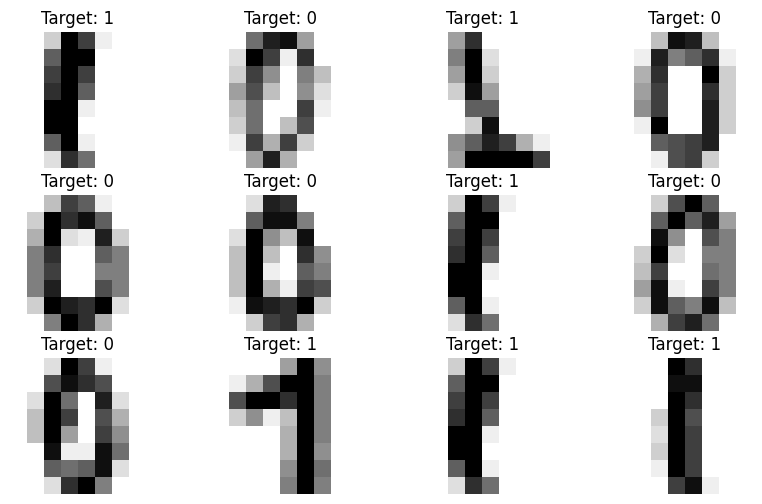

In [73]:
digits = datasets.load_digits()
X = digits.images[np.logical_or(digits.target == 0, digits.target == 1)]
Y = digits.target[np.logical_or(digits.target == 0, digits.target == 1)]
N = len(X)
print(N, len(Y[Y == 0]), len(Y[Y == 1]))

_, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
for ax in axes.flatten():
    idx = np.random.randint(N) 
    image = X[idx]
    label = Y[idx]
    
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Target: %i" % label)

**Exercise 3:** the goal of this exercise is to train a logistic regression model for the binary classification task of the simplified MNIST dataset above. Each image can be considered as a point in a 8x8=64 dimensional feature space. The target variable is binary: 0 or 1.

In the cell below, all the required functions are already given. Read the docstrings of the functions to understand the purpose of each of the functions. In the functions `compute_p`, `compute_gradient` and `train_logistic_regression` some lines of code are still missing. It is your job to complete the code and make sure the logistic regression model gets trained correctly.

Note that in the function `train_logistic_regression` we specify `batch_size` and `epochs`. The `batch_size` is the number of observations per minibatch and parameter update in the context of SGD. The integer `epochs` is the number of times the complete dataset is used for training. After one epoch, training continues with the first batch of the dataset. This batch has already been used at the very start of the training and is now used again. Each batch is used a total of `epochs` times.

In [74]:
def preprocess(X, Y, batch_size=None):
    """
    Data preprocessing. Flatten the features of the 2-dimensional image data and
    regroups the data in batches.
    """    
    N = len(X)
    X = X.reshape(N, -1)
    
    X = np.hstack((np.ones(N).reshape(-1,1), X))
    
    if batch_size is not None:
        n_batches = N // batch_size
        X = X[:n_batches*batch_size].reshape(n_batches, batch_size, -1)
        Y = Y[:n_batches*batch_size].reshape(n_batches, batch_size)
        
    return X, Y, N

def compute_p(X, beta, preprocessed=True):
    """
    Computes the modeled probability that of an image being of class 1.
    """
    if not preprocessed:
        N = len(X)
        X = X.reshape(N, -1)
        X = np.hstack((np.ones(N).reshape(-1,1), X))
    
    exp = np.exp(X @ beta)
    
    return exp / (1 + exp)

def compute_gradient(X, Y, beta):
    """
    Computes the gradient of the loss function (=minus log-likelihood).
    """
    p = compute_p(X, beta)
    
    return - (Y - p) @ X

def train_logistic_regression(X, Y, learning_rate=0.01, batch_size=20, epochs = 3, reporting=False):
    """
    Trains a logistic regression model using stochastic gradient descent. 
    """
    # get X in correct shape of batches, including intercept column
    X, Y, N = preprocess(X, Y, batch_size=batch_size)
    
    # initialize parameters
    n_features = X.shape[2] - 1
    beta = np.random.normal(loc=0.0, scale=1.0, size=(n_features+1,)) / np.max(X)
   
    i = 0
    while i < epochs:
        
        for j, X_batch in enumerate(X):
            
            Y_batch = Y[j]
            
            beta_old = beta
            gradient = compute_gradient(X_batch, Y_batch, beta_old)
            beta = beta_old - learning_rate * gradient
            
            if reporting:
                if j == 0: print("Epoch {}".format(i))
                if j % 5 == 0:
                    Y_predicted, _ = predict(X, beta, preprocessed=True)
                    compute_accuracy(Y_predicted, Y)
        
        i += 1  
    
    print("\nTraining is finished.\n")
    return beta

def predict(X, beta, preprocessed=False):
    """
    Binary classification based on logistic regression model.
    """
    p = compute_p(X, beta, preprocessed=preprocessed)
    Y_ = np.zeros(p.shape, dtype=int)
    Y_[p > 0.5] = 1
    
    return Y_, p

def compute_accuracy(Y_predicted, Y):
    """
    Computes prediction accuracy.
    """
    
    mistakes = np.sum(np.abs(Y_predicted - Y))
    accuracy = 1 - mistakes / np.size(Y)
    
    print("Accuracy: {:.1f}%".format(accuracy.round(2)*100))
    
    return accuracy

**Exercise 4:** run the cell below. It trains a logistic regression model and computes its accuracy on the training set. If `reporting=True` it also reports the training accuracy while training.

Play with the values of `learning_rate` and `epochs`. By doing so, try to get a training accuracy of near 100%.

In [75]:
beta_estimate = train_logistic_regression(X, Y, learning_rate=0.00001, batch_size=20, epochs = 3, reporting=True)

# Computes final training accuracy
Y_predicted, _ = predict(X, beta_estimate)
compute_accuracy(Y_predicted, Y)

Epoch 0
Accuracy: 31.0%
Accuracy: 32.0%
Accuracy: 38.0%
Accuracy: 45.0%
Epoch 1
Accuracy: 49.0%
Accuracy: 59.0%
Accuracy: 62.0%
Accuracy: 68.0%
Epoch 2
Accuracy: 71.0%
Accuracy: 76.0%
Accuracy: 81.0%
Accuracy: 84.0%

Training is finished.

Accuracy: 85.0%


np.float64(0.8527777777777777)